# (27) Awake -- plot

**Motivation**: Plot results. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
def default_props_awake(
        num_k: int = 7,
        perc: int = 15,
        **kwargs, ):
    mice = Mice(Config(
        nn=512,
        sub_ids=[2, 6, 7, 9, 10],
        ses_ids=[4],
        run_ids=range(1, 10 + 1),
    ))
    props_base = {
        'mice': mice,
        'num_k': num_k,
        'task': 'rest',
        'perc': f'p{perc}-sample',
        'metric': 'pearson',
        'sv_props': {
            'match_using': 'gam',
            'match_metric': 'euclidean'},
        'graph_type': 'real',
        'kw_kmeans': {'n_init': 100},
        'verbose': False,
    }
    kwargs = setup_kwargs(props_base, kwargs)
    props_ca = {'mode': 'ca2', **kwargs}
    return mice, props_ca

## Mice

In [3]:
mice, props = default_props_awake()
kws_show = show_kws(props['num_k'])
bs = Base(mice, mode='ca2')
bands = {
    (0.0, 5.0): 'Unfiltered',
    (0.01, 5.0): 'HP',
    (0.01, 0.5): CAS,
    (0.5, 5.0): CAF,
}
fig_dir = pjoin(fig_base_dir, 'rebuttal')
print(fig_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal

In [4]:
results = {}
for b in bands:
    mice.set_kws(band_ca2=b, desc_ca2='awake', task='rest')
    gr = Group(mice=mice, mode='ca2', perc='p15-sample', num_k=7)
    results[f"{bands[b]}\n{b}"] = gr.avg(ndim_start=1)
results_avg = {
    k: avg(v) for k, v
    in results.items()
}

In [5]:
src_key = (0.0, 5.0)
src_key = '\n'.join([
    bands[src_key],
    str(src_key),
])
global_order = 'infer'
match_metric = 'correlation'

In [6]:
gmap = find_best_mappings(
    data=results_avg,
    centroids=results_avg[src_key],
    match_metric=match_metric,
    global_order=global_order[0],
)

In [7]:
pi_sorted = {
    k: v[:, list(gmap[k].values()), :]
    for k, v in results.items()
}
pi_sorted_avg = {
    k: avg(v) for k, v
    in pi_sorted.items()
}

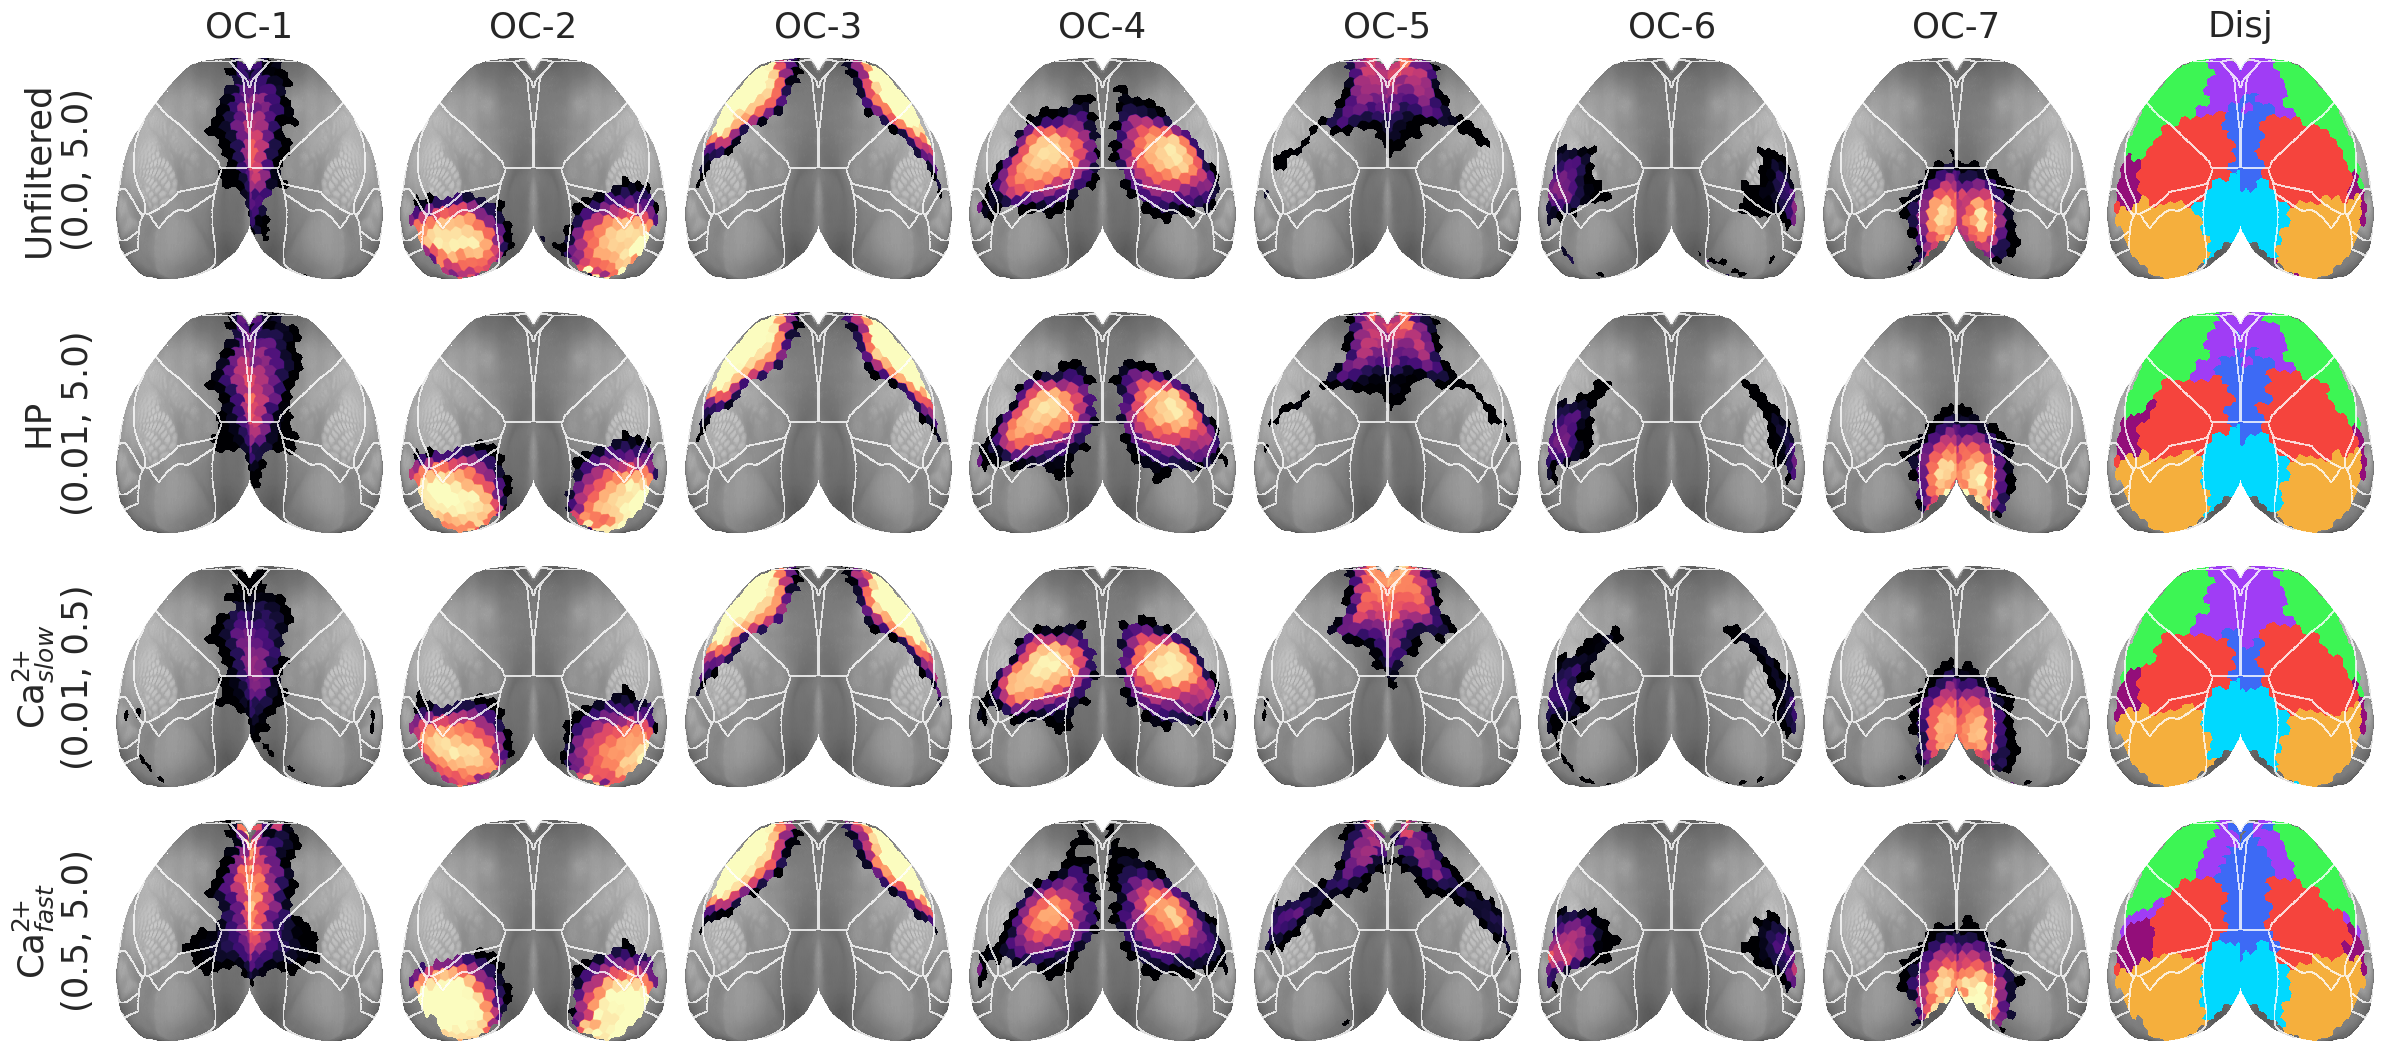

In [8]:
fig, axes = bs.show(pi_sorted_avg, **kws_show)

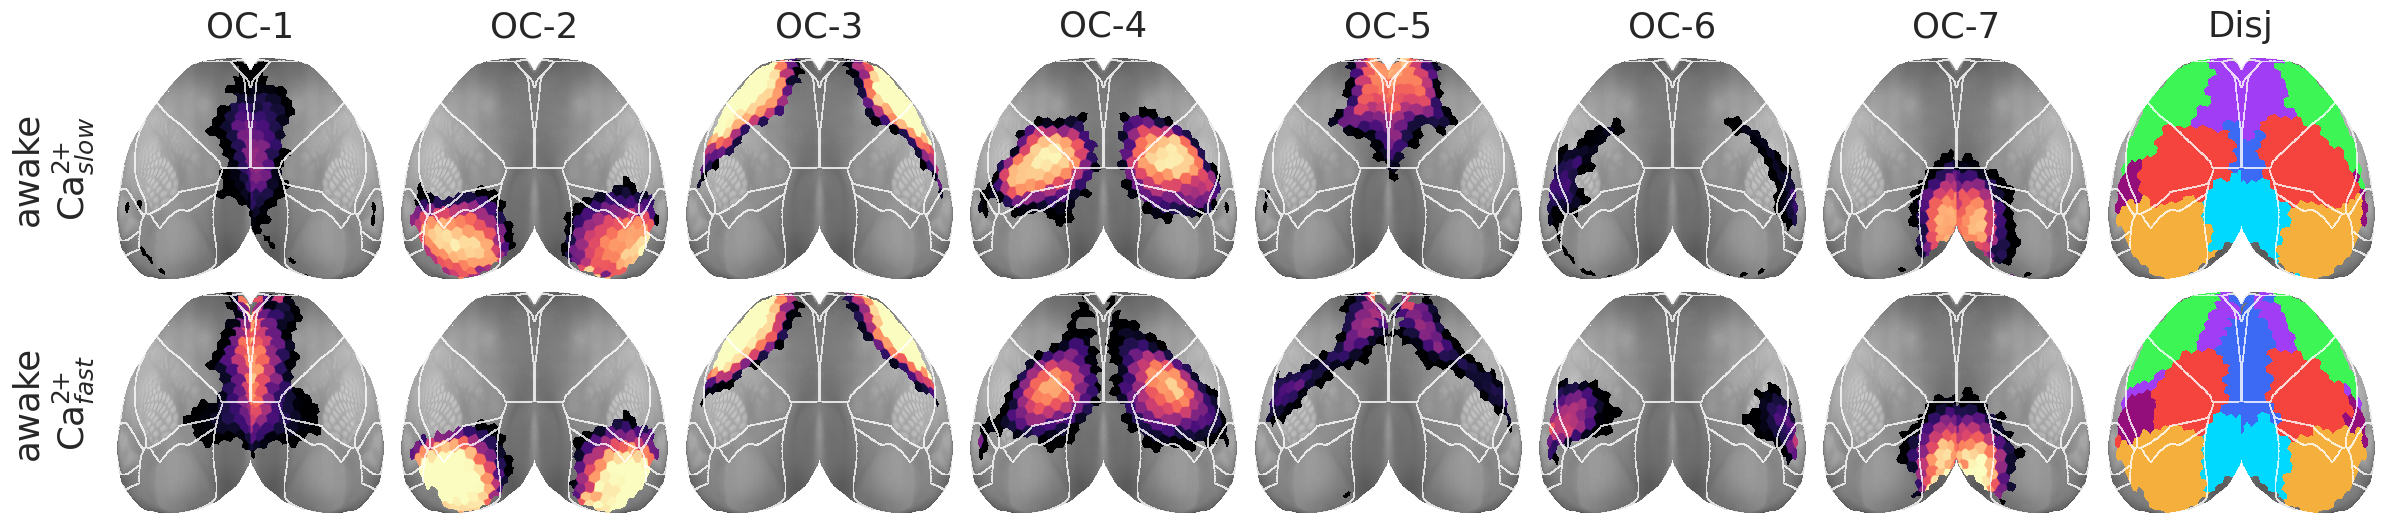

[PROGRESS] 'memberships_awake_avg.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [18]:
x = {
    k.split('\n')[0]: v for
    k, v in pi_sorted_avg.items()
    if 'slow' in k or 'fast' in k
}
x = {f"awake\n{k}": v for k, v in x.items()}
fig, axes = bs.show(x, **kws_show)

save_obj(
    obj=x,
    file_name='memberships_awake_avg.npy',
    save_dir=tmp_dir,
    mode='npy',
);

In [9]:
sim, sim_overall = cosine_sim(pi_sorted)

In [10]:
t = PrettyTable()
t.field_names = ['Band 1', 'Band 2', 'Overall'] + [f"OC-{i+1}" for i in range(7)]
for b1, b2 in itertools.combinations(bands, 2):
    k1 = f"{bands[b1]}\n{b1}"
    k2 = f"{bands[b2]}\n{b2}"
    vals = [
        str(b1).replace(' ', ''),
        str(b2).replace(' ', ''),
        f"{sim_overall[(k1, k2)].mean(0):0.3f}",
    ] + [f"{e:0.3f}" for e in np.diagonal(sim[(k1, k2)].mean(0))]
    t.add_row(vals)

In [11]:
print(t)

+------------+------------+---------+-------+-------+-------+-------+-------+-------+-------+
|   Band 1   |   Band 2   | Overall |  OC-1 |  OC-2 |  OC-3 |  OC-4 |  OC-5 |  OC-6 |  OC-7 |
+------------+------------+---------+-------+-------+-------+-------+-------+-------+-------+
| (0.0,5.0)  | (0.01,5.0) |  0.980  | 0.941 | 0.987 | 0.996 | 0.985 | 0.956 | 0.960 | 0.981 |
| (0.0,5.0)  | (0.01,0.5) |  0.965  | 0.930 | 0.979 | 0.994 | 0.975 | 0.935 | 0.909 | 0.963 |
| (0.0,5.0)  | (0.5,5.0)  |  0.948  | 0.913 | 0.982 | 0.988 | 0.964 | 0.826 | 0.925 | 0.962 |
| (0.01,5.0) | (0.01,0.5) |  0.975  | 0.938 | 0.990 | 0.997 | 0.991 | 0.925 | 0.939 | 0.981 |
| (0.01,5.0) | (0.5,5.0)  |  0.959  | 0.969 | 0.988 | 0.990 | 0.955 | 0.866 | 0.919 | 0.979 |
| (0.01,0.5) | (0.5,5.0)  |  0.907  | 0.887 | 0.973 | 0.982 | 0.925 | 0.730 | 0.803 | 0.951 |
+------------+------------+---------+-------+-------+-------+-------+-------+-------+-------+

## Save fig

In [49]:
kws_show['label_fontsize'] = 8
kws_show['figsize_x'] = 2.8
kws_show['figsize_y'] = 1.0
kws_show['display'] = False

kws_show

{
    'vmin': 0.2,
    'vmax': 0.9,
    'mask_thresh': 0.14285714285714285,
    'label_fontsize': 8,
    'add_disjoint': True,
    'add_title': True,
    'figsize_x': 2.8,
    'display': False,
    'figsize_y': 1.0
}

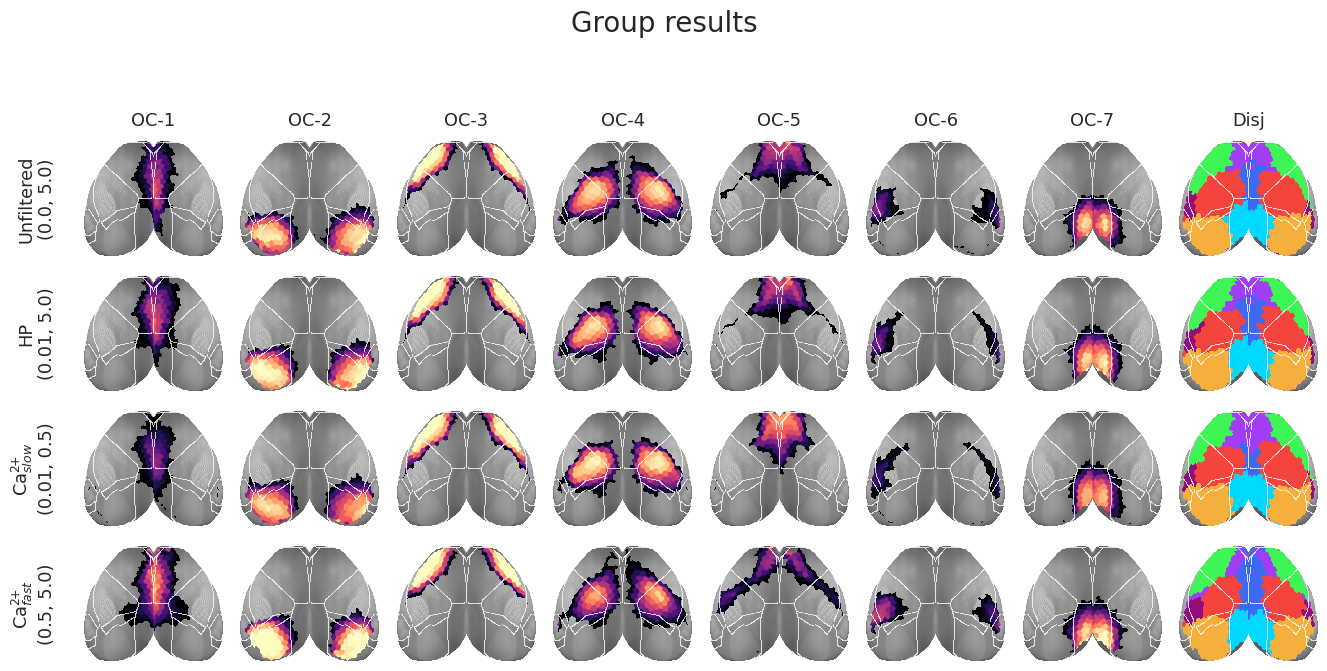

In [50]:
figs, sups = [], []

f, axes = bs.show(pi_sorted_avg, **kws_show)
s = f.suptitle('Group results', fontsize=20, y=1.06)

display(f)

In [56]:
figs, sups = [], []

f, axes = bs.show(pi_sorted_avg, **kws_show)
s = f.suptitle('Group results', fontsize=20, y=1.06)
f.savefig(
    pjoin(fig_dir, f"awake_ca2_group.png"),
    bbox_extra_artists=[s],
    bbox_inches='tight',
    dpi=200,
)
figs.append(f)
sups.append(s)

for i, sub in enumerate(mice.cfg.sub_ids):
    f, axes = bs.show(
        data={
            k: v[i] for k, v in
            pi_sorted.items()},
        **kws_show,
    )
    s = f.suptitle(mice.get_key(sub), fontsize=20, y=1.06)
    f.savefig(
        pjoin(fig_dir, f"awake_ca2_{sub}.png"),
        bbox_extra_artists=[s],
        bbox_inches='tight',
        dpi=200,
    )
    figs.append(f)
    sups.append(s)

In [57]:
save_fig(
    fig=figs,
    sup=sups,
    save_file=pjoin(fig_dir, 'awake_ca2.pdf'),
    multi=True,
)

In [60]:
total = count_sv_fitted(mice.cfg.svinet_dir, 'p15-sample')
remaining = {
    b: np.round(100 * sum(e == 0 for e in d.values()) / len(d), 1)
    for b, d in total.items()
}
remaining

{'(0.0,5.0)': 51.7, '(0.01,0.5)': 51.0, '(0.01,5.0)': 50.3, '(0.5,5.0)': 50.3}